# 0_subset_abc_atlas_to_thalamus

To subset the published ABC Atlas MERFISH dataset (3,739,961 cells) to cells that belong to the thalamus and/or the zona incerta (XXX cells), we used a combination of spatial and taxonomy-based labeling.

Functions for this process can be found in the `abc_load.py` & `abc_load_base.py` modules of the `thalamus-merfish-analysis` Python package.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

import seaborn as sns
import scipy.ndimage as ndi

%matplotlib inline

In [3]:
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg

## Load cell metadata DataFrame

In [4]:
cells_df = abc.get_combined_metadata(drop_unused=False)
print(f'n_cells in the whole-brain ABC Atlas: {cells_df.shape[0]}')

n_cells in the whole-brain ABC Atlas: 3739961


## Plotting helper functions

### def plot_th_mask_with_cell_overlay()

In [5]:
def plot_th_mask_with_cell_overlay(cell_df, th_mask, th_zi_sections, 
                                   hue_column='class', trim_to_th=True, 
                                   show_mask=True, title=''):

    # make a fixed colormap for displaying thalamus mask
    if show_mask:
        cmap_th_mask = colors.ListedColormap(['black', 'white'])
    else:
        cmap_th_mask = colors.ListedColormap(['white', 'white'])
    bounds=[0,1]
    norm = colors.BoundaryNorm(bounds, cmap_th_mask.N)

    # Create legend elements to label the cell colors
    color_col = hue_column+'_color'
    # .unique() returns hue_column & color_col values in a matched order
    categories = cell_df[hue_column].unique()
    cat_color_mapping = dict(zip(categories, cell_df[color_col].unique()))
    # sort both categories & cat_color_mapping so they appear in alpha category order in legend
    categories = sorted(categories)
    cat_color_mapping = dict(sorted(cat_color_mapping.items()))
    # create invisible objects to make legend handles
    legend_elements = [Line2D([0], [0], lw=0, marker='o', markersize=10,
                              markerfacecolor=cat_color_mapping[cat],
                              color=cat_color_mapping[cat], 
                              label=cat) 
                       for cat in cat_color_mapping]
    
    # Set up figure
    n_col = 2
    n_row = int(np.ceil(len(th_zi_sections) / n_col))
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*6,n_row*3.75))
    axes = axes.ravel()

    for i, sec in enumerate(th_zi_sections):
        ax = axes[i]

        curr_sec_cell_df = cell_df[(cell_df['z_reconstructed']==sec)]

        ax.imshow(th_mask[:,:,int(np.rint(sec/0.2))].T, extent=[0, 11, 11, 0], zorder=0,
                  cmap=cmap_th_mask, norm=norm)
        sc = ax.scatter(curr_sec_cell_df['x_reconstructed'], curr_sec_cell_df['y_reconstructed'],
                        color=curr_sec_cell_df['class_color'],
                        s=0.5, marker='.', zorder=1)
        ax.set_title('z_section = '+str(sec))

        ax.set_xlabel('x_reconstructed')
        ax.set_ylabel('y_reconstructed')
        if trim_to_th:
            x_min = 2; x_max = 9; y_min = 7.5; y_max = 3.5
            ax.set_xlim((x_min,x_max))
            ax.set_ylim((y_min,y_max))
        else:
            ax.set_xlim((0,11))
            ax.set_ylim((11,0))    
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        n_cols = 2 if len(categories) > 12 else 1
        if i==1:
            ax.legend(legend_elements, categories, title='class', ncol=n_cols, 
                      loc='center left', bbox_to_anchor=(1.1,0.5))
    plt.suptitle(title)
    plt.show()

## 1.) Spatial filtering based on ARA parcellations & CCFv3 image volumes

As an initial spatial filtering step, we used a rasterized anatomical annotation 
image volume, which aligns a resampled (10x10x??um) CCFv3 coordinate space into 
the MERFISH data space and where each voxel is assigned a parcellation index that 
uniquely identifies its assigned 3D Allen Reference Atlas (ARA) anatomical parcellation.

All the detailed steps outlined below are wrapped in the `label_thalamus_spatial_subset()` 
function from the `abc_load` module. We confirm this by showing that the number
of cells remaining after this single function call (227,417) is the same as the
number of cells remaining after detail step 1f (also 227,417).

In [6]:
cells_df_th_subset = abc.label_thalamus_spatial_subset(cells_df,
                                                       distance_px=20,
                                                       cleanup_mask=True,
                                                       drop_end_sections=True,
                                                       filter_cells=True)

print(f'n_cells after label_thalamus_spatial_subset(): {cells_df_th_subset.shape[0]}')

n_cells after label_thalamus_spatial_subset(): 227417


### 1a) Load & view CCF parcellation/annotation image volumes

`imshow()` colors each pixel by its parcellation_index. 
You can see that each ARA parcellation has its own color (displayed in grayscale).

ccf_img.shape=(1100, 1100, 76)


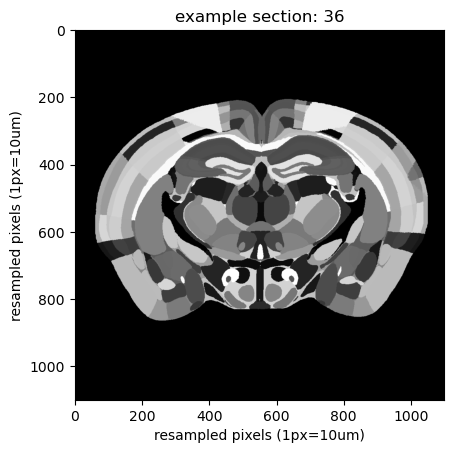

In [7]:
# loads the whole-brain CCF resampled_annotation image volumes
ccf_img = abc.get_ccf_labels_image(resampled=True)

# 1100x1100 pixels where each pixel is 10um^2; 76 sections
print(f'{ccf_img.shape=}')

# display an example section of the image volume that contains the thalamus 
zindex = 36 
plt.imshow(ccf_img[:,:,zindex].T, cmap='gray')  # transpose to plot in correct orientation
plt.title(f'example section: {zindex}')
xy_labels = 'resampled pixels (1px=10um)'
plt.xlabel(xy_labels); plt.ylabel(xy_labels)
plt.show()

### 1b) Generate binary mask for TH+ZI parcellation regions

We generated a binary TH+ZI mask that included all voxels labelled with a thalalmus 
(‘TH’) or a zona incerta (‘ZI’) associated parcellation index.

In [8]:
# get all parcellation names that are in either TH or ZI
ccf_regions_to_select = ['TH', 'ZI'] # TH = thalamus ; ZI = zona incerta
ccf_regions = abc.get_ccf_names(top_nodes=ccf_regions_to_select, 
                                level='substructure')
print(f'{ccf_regions=}')

# convert parcellation names to the unique parcellation_index used in the image volume
ccf_index = abc.get_ccf_index(level='substructure')
reverse_lookup = pd.Series(ccf_index.index.values, index=ccf_index)
th_zi_index_values = reverse_lookup.loc[ccf_regions]
print(f'{th_zi_index_values[:5]=} \netc. ...')

ccf_regions=['AD', 'AMd', 'AMv', 'AV', 'CL', 'CM', 'Eth', 'FF', 'IAD', 'IAM', 'IGL', 'IMD', 'IntG', 'LD', 'LGd-co', 'LGd-ip', 'LGd-sh', 'LGv', 'LH', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 'MH', 'PCN', 'PF', 'PIL', 'PO', 'POL', 'PP', 'PR', 'PT', 'PVT', 'PoT', 'RE', 'RH', 'RT', 'SGN', 'SMT', 'SPA', 'SPFm', 'SPFp', 'SubG', 'TH-unassigned', 'VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'Xi', 'ZI']
th_zi_index_values[:5]=parcellation_term_acronym
AD       59
AMd    1085
AMv    1093
AV      248
CL      565
dtype: int64 
etc. ...


In [9]:
# if you want to subset by a different ARA parcellation region, you can change 
# the `level` param {'division', 'structure', 'substructure'} to view alterative
# options to add to `ccf_regions_to_select` in the previous cell
all_division_names = abc.get_ccf_names(top_nodes=None, level='division')
print(all_division_names)

['Isocortex' 'OLF' 'HPF' 'CTXsp' 'STR' 'PAL' 'TH' 'HY' 'MB' 'P' 'MY' 'CB'
 'cm' 'cbf' 'scwm' 'lfbs' 'eps' 'mfbs' 'VL' 'V3' 'AQ' 'V4' 'c'
 'unassigned' 'brain-unassigned' 'fiber tracts-unassigned']


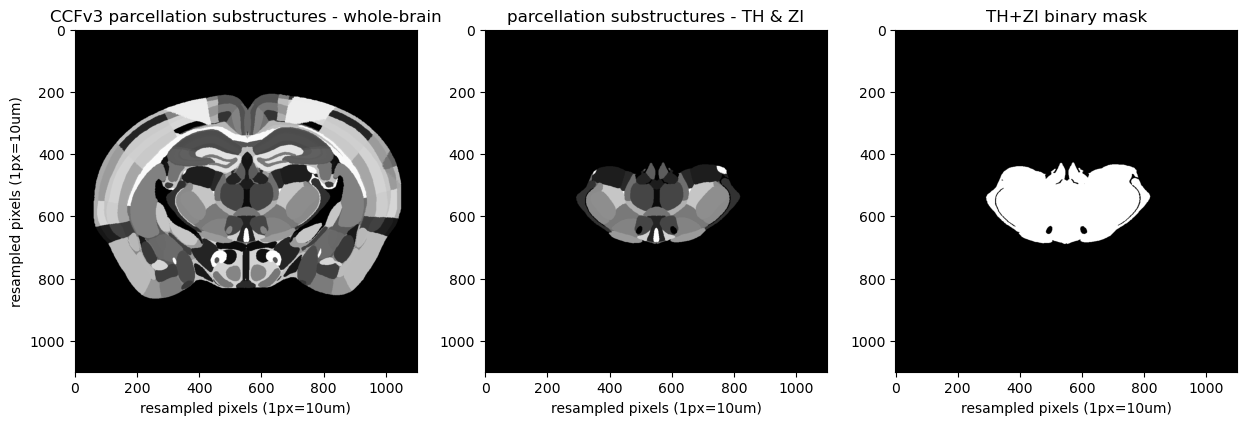

In [10]:
# generate a binary TH+ZI mask
th_zi_mask = np.isin(ccf_img, th_zi_index_values)

# subset the ccf image volume using the binary mask
th_zi_img = np.where(th_zi_mask, ccf_img, 0)


# display the subsetted image volume and TH+ZI binary mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
xy_labels = 'resampled pixels (1px=10um)'

ax1.imshow(ccf_img[:,:,zindex].T, cmap='gray')
ax1.set_title('CCFv3 parcellation substructures - whole-brain')
ax1.set_xlabel(xy_labels); ax1.set_ylabel(xy_labels)

ax2.imshow(th_zi_img[:,:,zindex].T, cmap='gray')
ax2.set_title('parcellation substructures - TH & ZI')
ax2.set_xlabel(xy_labels)

ax3.imshow(th_zi_mask[:,:,zindex].T, cmap='gray')
ax3.set_title('TH+ZI binary mask')
ax3.set_xlabel(xy_labels)

plt.show()

### 1c) Dilate TH+ZI binary mask by 20px (200um)
Potentially misaligned TH or ZI cells were captured by dilating the binary mask 
by 20 pixels (200um).

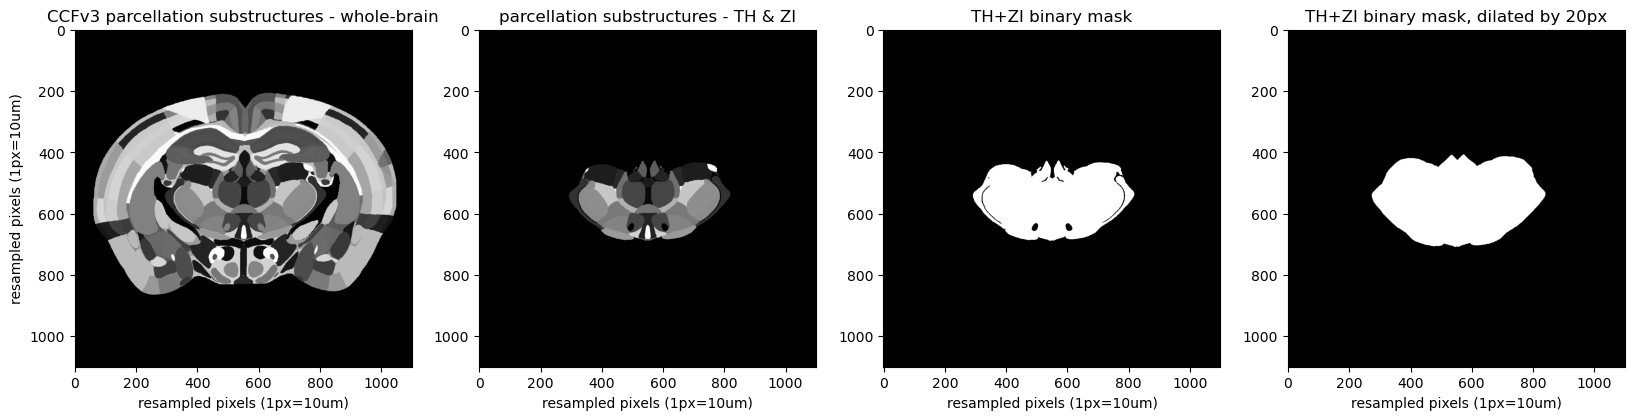

In [11]:
# 20px=200um
th_zi_mask_dilated = abc.sectionwise_dilation(th_zi_mask, distance_px=20)


# display the subsetted image volume and TH+ZI binary mask
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
xy_labels = 'resampled pixels (1px=10um)'

ax1.imshow(ccf_img[:,:,zindex].T, cmap='gray')
ax1.set_title('CCFv3 parcellation substructures - whole-brain')
ax1.set_xlabel(xy_labels); ax1.set_ylabel(xy_labels)

ax2.imshow(th_zi_img[:,:,zindex].T, cmap='gray')
ax2.set_title('parcellation substructures - TH & ZI')
ax2.set_xlabel(xy_labels)

ax3.imshow(th_zi_mask[:,:,zindex].T, cmap='gray')
ax3.set_title('TH+ZI binary mask')
ax3.set_xlabel(xy_labels)

ax4.imshow(th_zi_mask_dilated[:,:,zindex].T, cmap='gray')
ax4.set_title('TH+ZI binary mask, dilated by 20px')
ax4.set_xlabel(xy_labels)

plt.show()

### 1d) Clean up the binary mask

This step was implemented to correct a particular section (shown below)

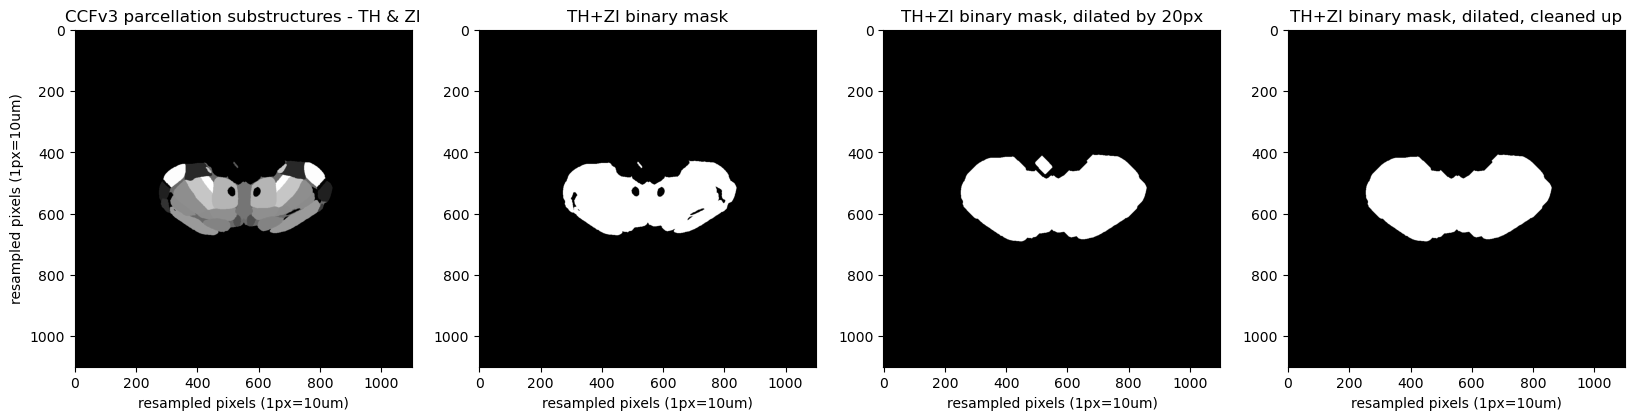

In [12]:
# clean up the binary mask to remove small, erroneous mask regions
th_zi_mask_dilated_clean = cimg.cleanup_mask_regions(th_zi_mask_dilated, 
                                                     area_ratio_thresh=0.1)


# display the subsetted image volume and TH+ZI binary mask
zindex = 32
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
xy_labels = 'resampled pixels (1px=10um)'

ax1.imshow(th_zi_img[:,:,zindex].T, cmap='gray')
ax1.set_title('CCFv3 parcellation substructures - TH & ZI')
ax1.set_xlabel(xy_labels); ax1.set_ylabel(xy_labels)

ax2.imshow(th_zi_mask[:,:,zindex].T, cmap='gray')
ax2.set_title('TH+ZI binary mask')
ax2.set_xlabel(xy_labels)

ax3.imshow(th_zi_mask_dilated[:,:,zindex].T, cmap='gray')
ax3.set_title('TH+ZI binary mask, dilated by 20px')
ax3.set_xlabel(xy_labels)

ax4.imshow(th_zi_mask_dilated_clean[:,:,zindex].T, cmap='gray')
ax4.set_title('TH+ZI binary mask, dilated, cleaned up')
ax4.set_xlabel(xy_labels)

plt.show()

### 1e) Label & filter using spatial mask

This reduces the dataset to 233,340 cells from 16 coronal sections.

In [13]:
# label cells that fall within the TH+ZI mask
field_name='TH_ZI_dataset'
coords = ['x_reconstructed','y_reconstructed','z_reconstructed']
resolutions = np.array([10e-3, 10e-3, 200e-3])
cells_df[field_name] = th_zi_mask_dilated_clean[cimg.image_index_from_coords(cells_df[coords], resolutions)]
# cells_df = abc_load_base._label_masked_cells(cells_df, th_zi_mask_dilated, coords, resolutions, field_name=field_name)

# filter out cells that do not fall within the TH+ZI mask
th_zi_cells_df = cells_df[cells_df[field_name]].copy().drop(columns=[field_name])

print(f'n_cells after spatial filtering: {th_zi_cells_df.shape[0]}')

n_cells after spatial filtering: 232802


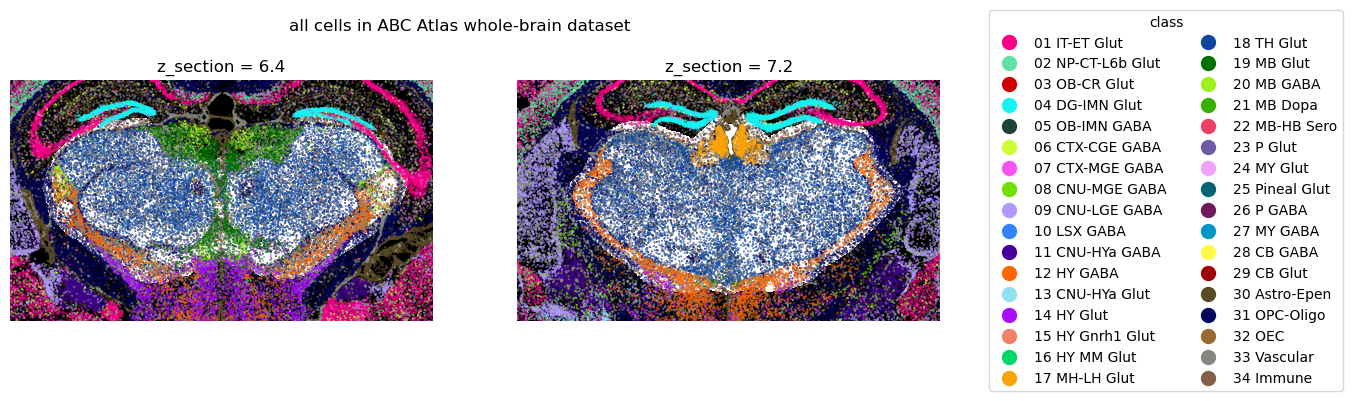

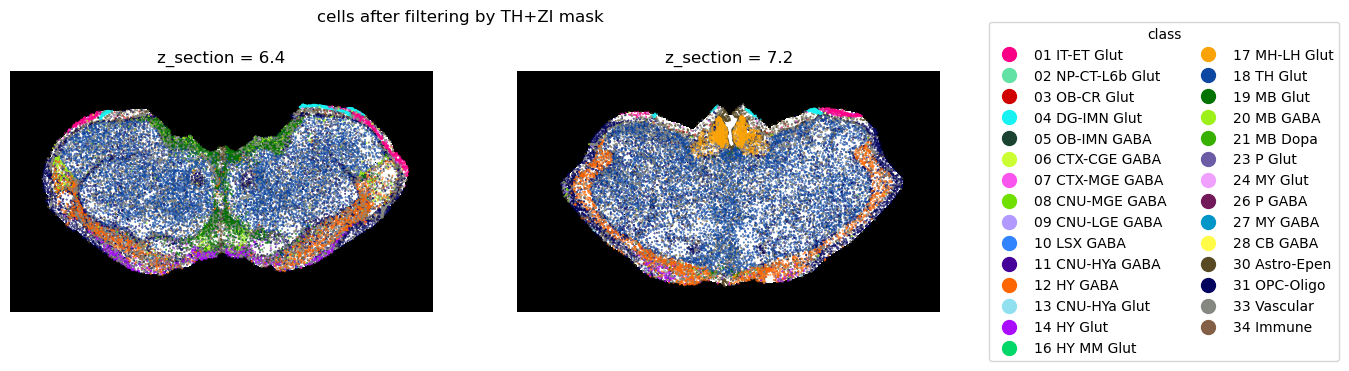

In [14]:
sections_example_2 = [6.4, 7.2]

# show dataset before any spatial filtering in two example sections
plot_th_mask_with_cell_overlay(cells_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='all cells in ABC Atlas whole-brain dataset')

# show dataset before any spatial filtering in two example sections
plot_th_mask_with_cell_overlay(th_zi_cells_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='cells after filtering by TH+ZI mask')

### 1f) Drop the anterior-most section and posterior-most section

At this stage, we also filtered out all cells from the anterior-most section and 
the posterior-most section that contained TH and ZI cells due to poor alignment 
between the CCFv3 TH+ZI parcellation regions and cells mapping to thalamic cell 
types, as determined by visual inspection. This further reduced the dataset to 
227,417 cells and 14 coronal sections. 

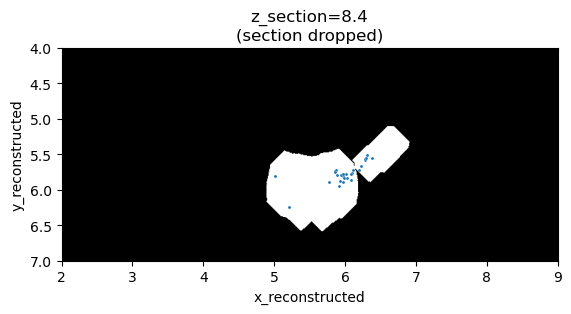

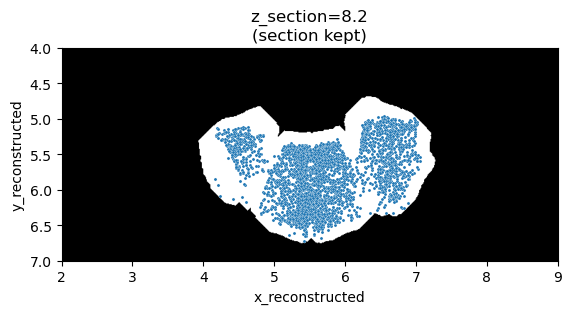

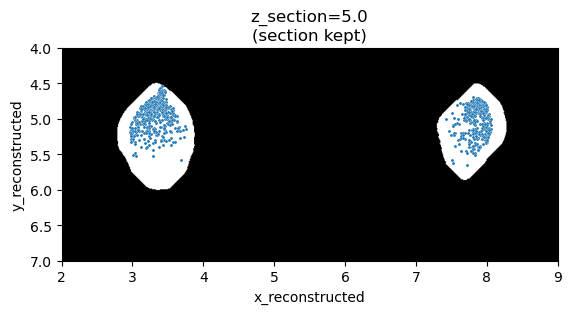

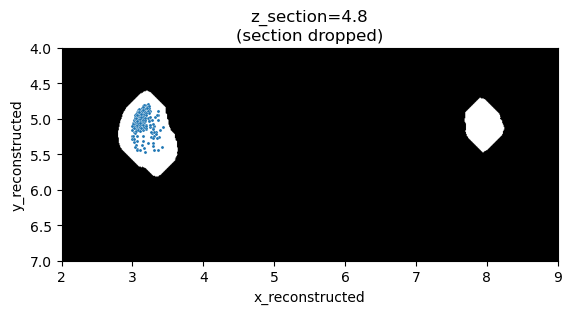

In [15]:
z_sections = [8.4, 8.2, 5.0, 4.8]
th_classes = abc.TH_ZI_CLASSES

# Display the TH+ZI mask with the cells overlayed on top to show that TH cells 
# in sections 8.4 and 4.8 have poor overlap with the TH mask
for z_sec in z_sections:
    z_img = int(np.rint(z_sec/0.2))
    sec_df = th_zi_cells_df[(th_zi_cells_df['z_reconstructed']==z_sec) & 
                            (th_zi_cells_df['class'].isin(th_classes))]
    plt.imshow(th_zi_mask_dilated_clean[:,:,z_img].T, cmap='gray', extent=[0, 11, 11, 0])
    sns.scatterplot(data=sec_df, x='x_reconstructed', y='y_reconstructed', s=5)
    if (z_sec==8.4) | (z_sec==4.8):
        plt.title(f'z_section={z_sec}\n(section dropped)')
    else:
        plt.title(f'z_section={z_sec}\n(section kept)')
    plt.ylim(7, 4)
    plt.xlim(2, 9)
    plt.show()

In [16]:
# anterior-most section that is dropped: z_section=8.4
# posterior-most section that is dropped: z_section=4.8
th_zi_cells_df = th_zi_cells_df.query("5.0 <= z_section <= 8.2")

print(f'n_cells after end section drop: {th_zi_cells_df.shape[0]}')

n_cells after end section drop: 227417


## 2.) Cell-type filtering based on mapped subclasses

We then filtered out cells based on their mapped cell types, using the class 
level of the scRNAseq hierarchical taxonomy. 

First, we filtered out cells belonging to the four non-neuronal classes 
('30 Astro-Epen', '31 OPC-Oligo', '33 Vascular', and '34 Immune'). 

We determined that nearly all neurons in the TH and ZI belonged to just 3 
classes ('12 HY GABA', '17 MH-LH Glut', and '18 TH Glut'), with a small 
percentage of cells in the TH—including interneurons in the LGd—mapping to two 
midbrain classes ('19 MB Glut' and '20 MB GABA'). We then filtered out all 
neurons that did not belong to one of these five classes, which created a 
dataset with 92,923 neurons. 

In [17]:
# groups of classes are pre-defined in the `abc_load` module
print(f'{abc.NN_CLASSES=}')
print(f'{abc.TH_ZI_CLASSES=}')
print(f'{abc.MB_CLASSES=}')

abc.NN_CLASSES=['30 Astro-Epen', '31 OPC-Oligo', '33 Vascular', '34 Immune']
abc.TH_ZI_CLASSES=['12 HY GABA', '17 MH-LH Glut', '18 TH Glut']
abc.MB_CLASSES=['19 MB Glut', '20 MB GABA']


In [18]:
th_zi_neurons_df = abc.filter_by_class_thalamus(th_zi_cells_df, 
                                                filter_nonneuronal=True,
                                                filter_midbrain=False, 
                                                filter_other_nonTH=True)

print(f'n_neurons after cell type filtering: {th_zi_neurons_df.shape[0]}')

n_neurons after cell type filtering: 92923


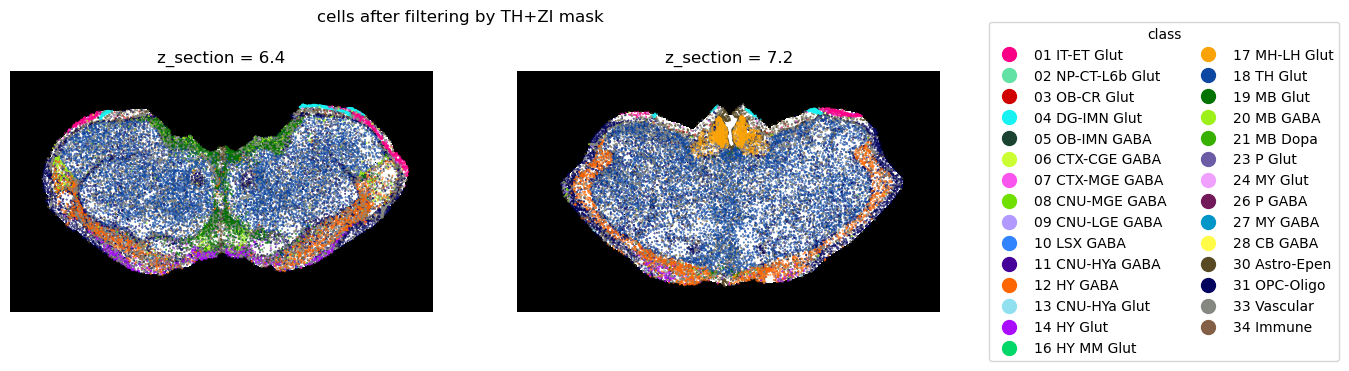

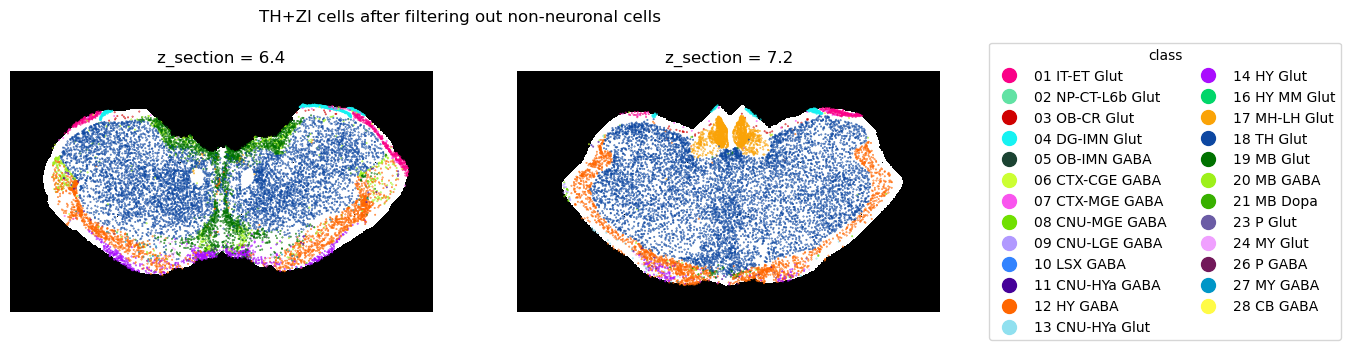

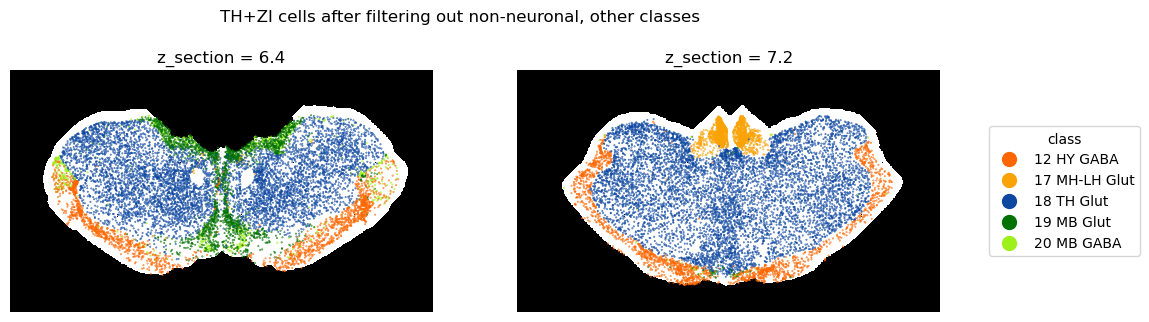

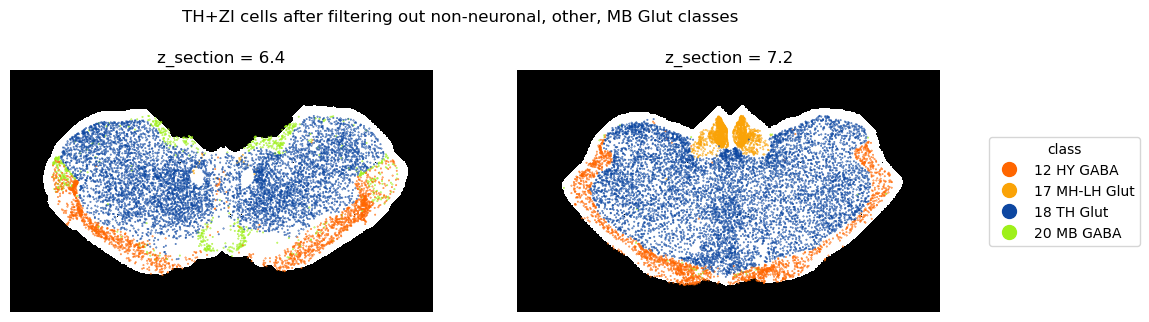

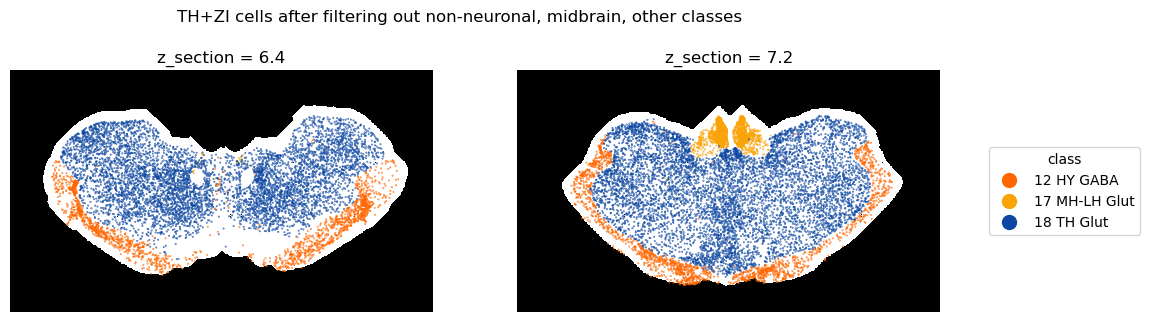

In [19]:
sections_example_2 = [6.4, 7.2]

# show dataset after spatial filtering in two example sections
plot_th_mask_with_cell_overlay(th_zi_cells_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='cells after filtering by TH+ZI mask')

# show dataset after filtering out just non-neuronal classes
neurons_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES)
plot_th_mask_with_cell_overlay(neurons_test_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='TH+ZI cells after filtering out non-neuronal cells')

# show dataset after filtering out non-neuronal classes & non-TH, non-ZI, non-MB classes
th_mb_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES,
                                    include=abc.TH_ZI_CLASSES+abc.MB_CLASSES)
plot_th_mask_with_cell_overlay(th_mb_test_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='TH+ZI cells after filtering out non-neuronal, other classes')

# show dataset after filtering out non-neuronal classes & non-TH, non-ZI, non-MB classes
th_mb_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES,
                                    include=abc.TH_ZI_CLASSES+['20 MB GABA'])
plot_th_mask_with_cell_overlay(th_mb_test_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='TH+ZI cells after filtering out non-neuronal, other, MB Glut classes')

# show dataset after filtering out non-neuronal classes, MB classes, and non-TH & non-ZI classes
th_test_df = abc.filter_by_class(th_zi_cells_df, exclude=abc.NN_CLASSES,
                                 include=abc.TH_ZI_CLASSES)
plot_th_mask_with_cell_overlay(th_test_df, th_zi_mask_dilated_clean, 
                               sections_example_2, trim_to_th=True,
                               title='TH+ZI cells after filtering out non-neuronal, midbrain, other classes')

## 3.) Spatial Refinement

We did a final spatial refinement step to filter the remaining cells by the same 
anatomical annotation image volume as before, but this time with the dilation 
buffer set to 0 pixels. 

This produced our final TH+ZI neuronal subset of the ABC Atlas with 92,923 neurons in 14 coronal sections. 

In [20]:
th_zi_neurons_df_FINAL = abc.filter_by_thalamus_coords(th_zi_neurons_df, 
                                                       buffer=0  # 0 pixels (1px=10um)
                                                       )

print(f'n_neurons after spatial refinement (final TH+ZI dataset): {th_zi_neurons_df_FINAL.shape[0]}')

n_neurons after spatial refinement (final TH+ZI dataset): 79158


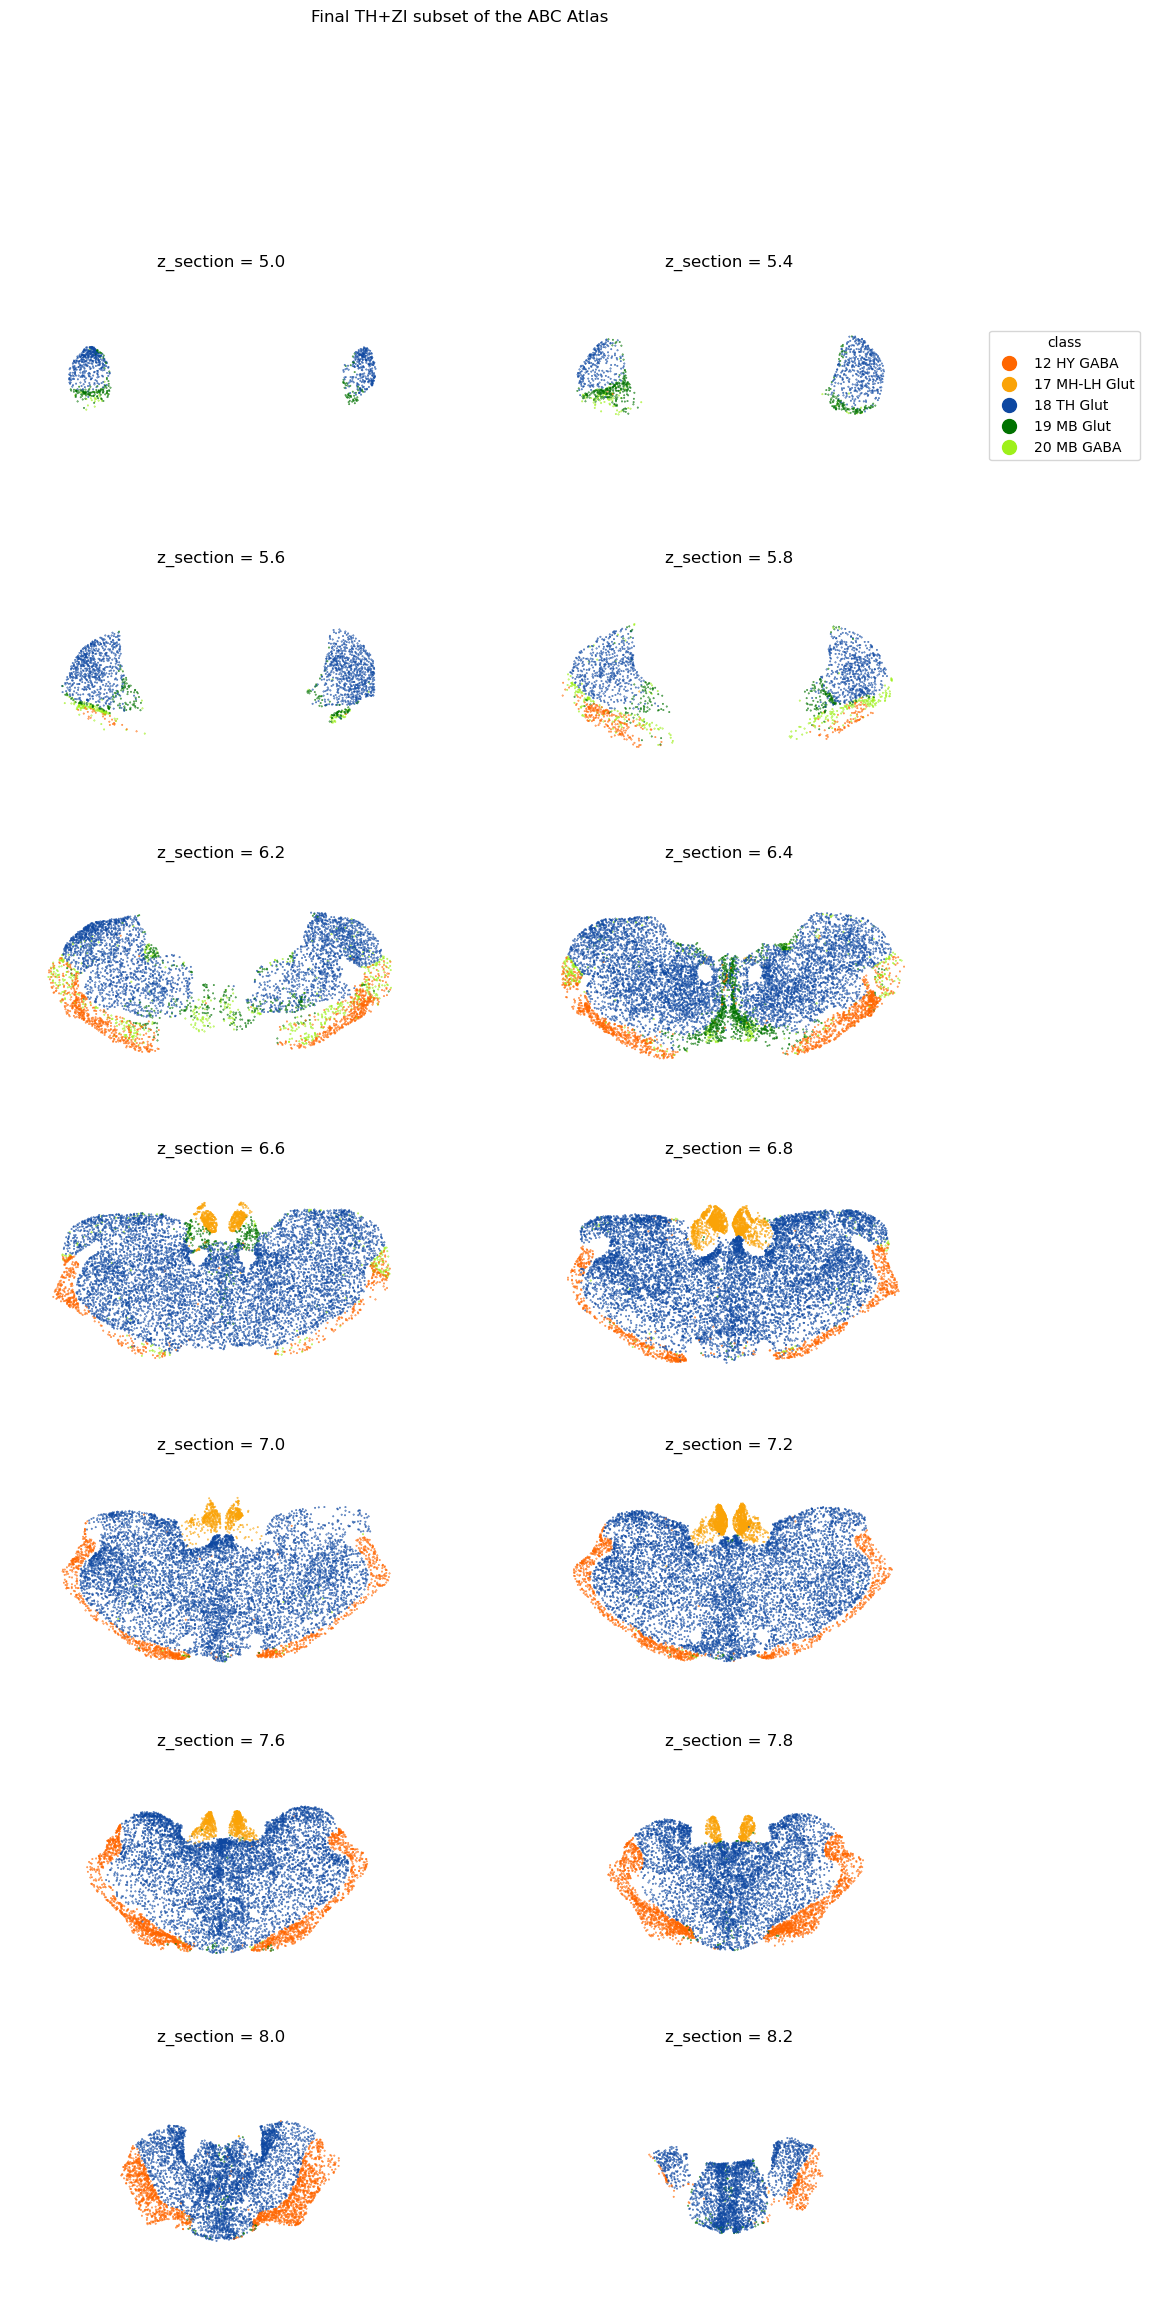

In [21]:
sections_th_all = sorted(th_zi_neurons_df_FINAL['z_section'].unique())

# show dataset after spatial filtering in two example sections
plot_th_mask_with_cell_overlay(th_zi_neurons_df_FINAL, th_zi_mask, 
                               sections_th_all, trim_to_th=True, show_mask=False,
                               title='Final TH+ZI subset of the ABC Atlas')